# **Data Loading and Preprocessing**

In [154]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [155]:
path='/content/data.csv'
df=pd.read_csv(path,delimiter=',',encoding="ISO-8859-1")
df.head()

InvoiceNo StockCode                          Description  ...  UnitPrice CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER  ...       2.55    17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN  ...       3.39    17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER  ...       2.75    17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE  ...       3.39    17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.  ...       3.39    17850.0  United Kingdom

[5 rows x 8 columns]

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [157]:
df.describe().T # for numeric values

count          mean          std       min       25%       50%       75%      max
Quantity    541909.0      9.552250   218.081158 -80995.00      1.00      3.00     10.00  80995.0
UnitPrice   541909.0      4.611114    96.759853 -11062.06      1.25      2.08      4.13  38970.0
CustomerID  406829.0  15287.690570  1713.600303  12346.00  13953.00  15152.00  16791.00  18287.0

In [158]:
df.describe(exclude=['int64','float64']).T # for other columns

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
InvoiceDate  541909  23260                    10/31/2011 14:41    1114
Country      541909     38                      United Kingdom  495478

In [159]:
df.isnull().sum()

# description and customerID have null values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [160]:
df.shape

(541909, 8)

In [161]:
# we can drop the null values since we have many records
df.dropna(inplace=True)

In [162]:
df.isnull().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [163]:
# let's understand the data further

df[df['Quantity']<0].shape # there are 8905 negative values for quantity

(8905, 8)

In [164]:
df.drop(df[df['Quantity']<0].index,inplace=True)

In [165]:
df.shape

(397924, 8)

In [166]:
# let's create a new column  as total amount = qunatity x unitPrice

df['TotalAmount']=df['Quantity']*df['UnitPrice']
new_df=df.groupby('CustomerID')['TotalAmount'].sum().reset_index() # total amount spent by customer

In [167]:
new_df.head()

CustomerID  TotalAmount
0     12346.0     77183.60
1     12347.0      4310.00
2     12348.0      1797.24
3     12349.0      1757.55
4     12350.0       334.40

In [168]:
# let's create another df which tells about the number of transactions made by each customer

num_trans=df.groupby('CustomerID')['InvoiceNo'].count().reset_index()

In [169]:
num_trans.head()

CustomerID  InvoiceNo
0     12346.0          1
1     12347.0        182
2     12348.0         31
3     12349.0         73
4     12350.0         17

In [170]:
# let's see the no of days completed after the last transaction every customer is doing

df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df.head()

InvoiceNo StockCode                          Description  ...  CustomerID         Country  TotalAmount
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER  ...     17850.0  United Kingdom        15.30
1    536365     71053                  WHITE METAL LANTERN  ...     17850.0  United Kingdom        20.34
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER  ...     17850.0  United Kingdom        22.00
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE  ...     17850.0  United Kingdom        20.34
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.  ...     17850.0  United Kingdom        20.34

[5 rows x 9 columns]

In [171]:
# let's see the number of days completed after the last transaction every customer is doing

df['last transaction']=(df['InvoiceDate'].max()-df['InvoiceDate']).dt.days

In [172]:
df.head()

InvoiceNo StockCode  ... TotalAmount  last transaction
0    536365    85123A  ...       15.30               373
1    536365     71053  ...       20.34               373
2    536365    84406B  ...       22.00               373
3    536365    84029G  ...       20.34               373
4    536365    84029E  ...       20.34               373

[5 rows x 10 columns]

In [173]:
last_trans=df.groupby(['CustomerID','Country'])['last transaction'].max().reset_index()

In [174]:
last_trans.head()

CustomerID         Country  last transaction
0     12346.0  United Kingdom               325
1     12347.0         Iceland               366
2     12348.0         Finland               357
3     12349.0           Italy                18
4     12350.0          Norway               309

In [175]:
# let's merge all the dfs obtained

merged_df0=pd.merge(last_trans,num_trans,on='CustomerID',how='inner')
merged_df=pd.merge(merged_df0,new_df,on='CustomerID',how='inner')
merged_df.head()

CustomerID         Country  last transaction  InvoiceNo  TotalAmount
0     12346.0  United Kingdom               325          1     77183.60
1     12347.0         Iceland               366        182      4310.00
2     12348.0         Finland               357         31      1797.24
3     12349.0           Italy                18         73      1757.55
4     12350.0          Norway               309         17       334.40

In [176]:
merged_df.shape

(4347, 5)

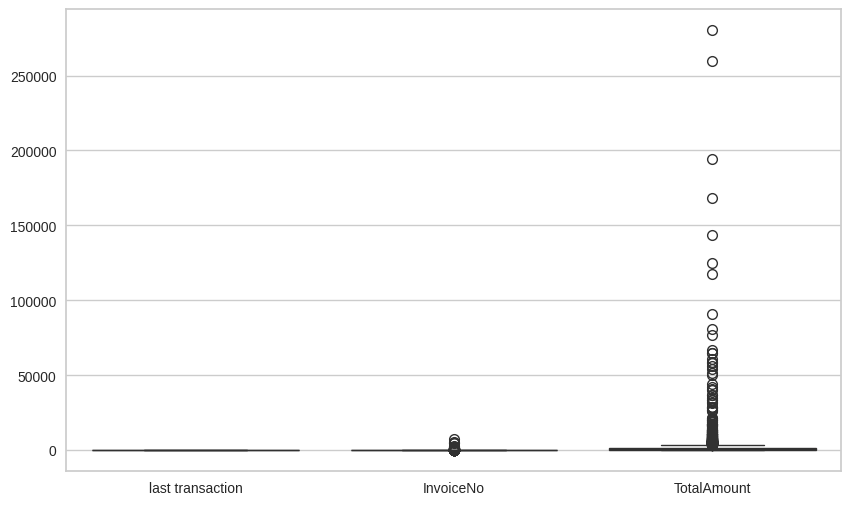

In [177]:
# let's remove the outliers

plt.figure(figsize=(10,6))
sns.boxplot(merged_df[['last transaction','InvoiceNo','TotalAmount']])
plt.show()

In [178]:
# lets remove the outliers in the TotalAmount

IQR=merged_df['TotalAmount'].quantile(0.75)-merged_df['TotalAmount'].quantile(0.25)
lower_limit=merged_df['TotalAmount'].quantile(0.25)-(IQR*1.5)
upper_limit=merged_df['TotalAmount'].quantile(0.75)+(IQR*1.5)
df=merged_df[(merged_df['TotalAmount']>lower_limit)&(merged_df['TotalAmount']<upper_limit)]
df.shape

(3923, 5)

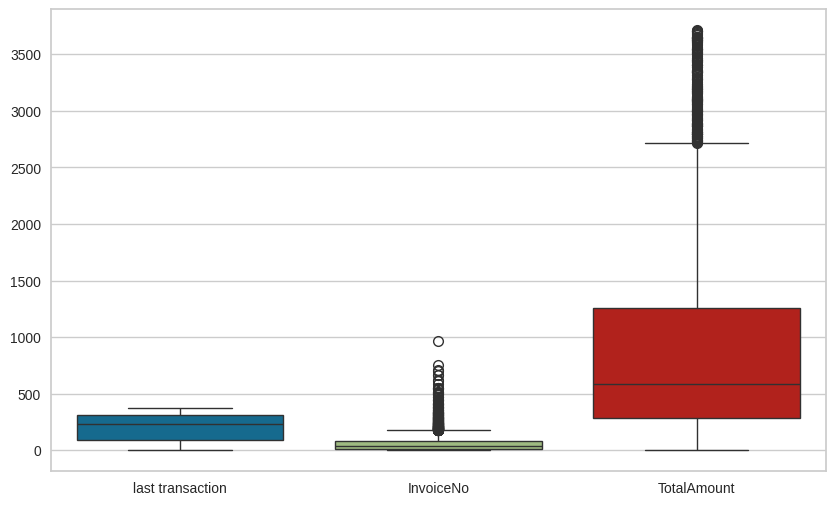

In [179]:
plt.figure(figsize=(10,6))
sns.boxplot(df[['last transaction','InvoiceNo','TotalAmount']])
plt.show()

In [180]:
df.reset_index(drop=True,inplace=True)

In [181]:
# still there are outliers. for now,we can stop here

In [182]:
df.head()

CustomerID  Country  last transaction  InvoiceNo  TotalAmount
0     12348.0  Finland               357         31      1797.24
1     12349.0    Italy                18         73      1757.55
2     12350.0   Norway               309         17       334.40
3     12352.0   Norway               296         85      2506.04
4     12353.0  Bahrain               203          4        89.00

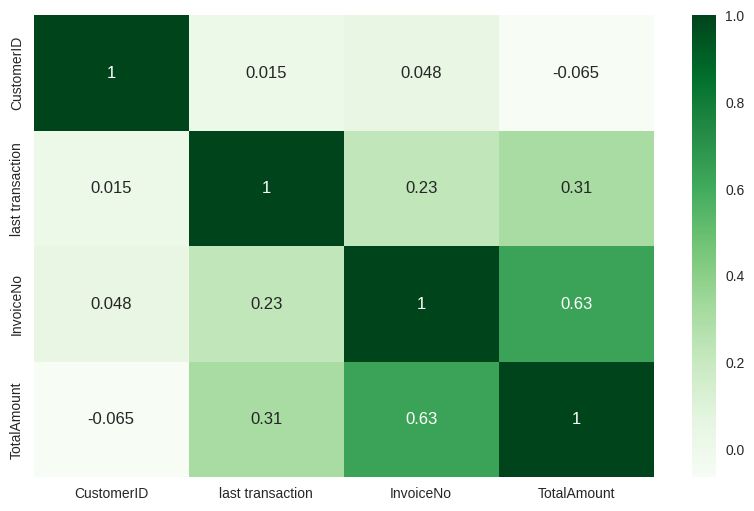

In [183]:
# heatmap
df_corr=df.drop('Country',axis=1) # it is not numerical
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(),cmap='Greens',annot=True)
plt.show()

In [184]:
# normalization
from sklearn.preprocessing import MinMaxScaler
df_scale=df[['last transaction','InvoiceNo','TotalAmount']] # numerical features
scaler=MinMaxScaler()
df_scale=scaler.fit_transform(df_scale)
df_scale=pd.DataFrame(df_scale,columns=['last transaction','InvoiceNo','TotalAmount'])

# add the customerID and country column
df_scale['CustomerID']=df['CustomerID']
df_scale['Country']=df['Country']
df_scale.head()

last transaction  InvoiceNo  TotalAmount  CustomerID  Country
0          0.957105   0.030960     0.484200     12348.0  Finland
1          0.048257   0.074303     0.473507     12349.0    Italy
2          0.828418   0.016512     0.090092     12350.0   Norway
3          0.793566   0.086687     0.675160     12352.0   Norway
4          0.544236   0.003096     0.023978     12353.0  Bahrain

# **K-Means Clustering**

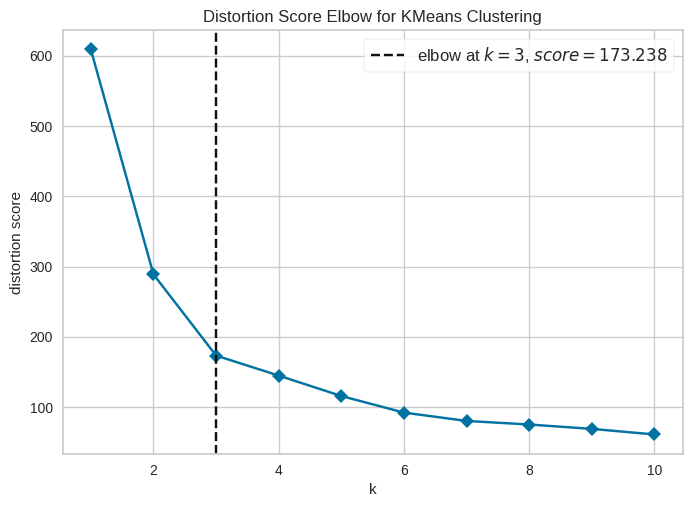

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [185]:
df=df_scale.drop(['Country','CustomerID'],axis=1)

# Elbow Method
from yellowbrick.cluster import KElbowVisualizer
model=KMeans() # initial the centroids by kmeans++ default
visualizer=KElbowVisualizer(model,k=(1,11),timings=False)
visualizer.fit(df)
visualizer.show() # score is WCSS

In [186]:
# best k is 3
kmeans=KMeans(n_clusters=3)
pred=kmeans.fit_predict(df)
df['Cluster']=pred
df.head()

last transaction  InvoiceNo  TotalAmount  Cluster
0          0.957105   0.030960     0.484200        2
1          0.048257   0.074303     0.473507        0
2          0.828418   0.016512     0.090092        1
3          0.793566   0.086687     0.675160        2
4          0.544236   0.003096     0.023978        1

In [187]:
# final centroids
kmeans.cluster_centers_

array([[0.22076895, 0.04001774, 0.14851301],
       [0.77665026, 0.04271404, 0.15749496],
       [0.79796367, 0.15825709, 0.63324065]])

In [188]:
kmeans.labels_

array([2, 0, 1, ..., 0, 2, 2], dtype=int32)

In [189]:
# model evaluation
from sklearn.metrics import silhouette_score
score=silhouette_score(df,kmeans.labels_,metric='euclidean') # remember that the parmeters are final features and  cluster labels
print(score)

0.7738379838035234


In [190]:
score=silhouette_score(df,kmeans.labels_,metric='manhattan') # remember that the parmeters are final features and  cluster labels
print(score)

0.7864674065083205


# **Hierarchical Clustering**

In [191]:
from sklearn.cluster import AgglomerativeClustering
hierarchical=AgglomerativeClustering(n_clusters=3)
pred_H=hierarchical.fit_predict(df)
df['Cluster_H']=pred_H
df.head()

last transaction  InvoiceNo  TotalAmount  Cluster  Cluster_H
0          0.957105   0.030960     0.484200        2          2
1          0.048257   0.074303     0.473507        0          1
2          0.828418   0.016512     0.090092        1          0
3          0.793566   0.086687     0.675160        2          2
4          0.544236   0.003096     0.023978        1          0

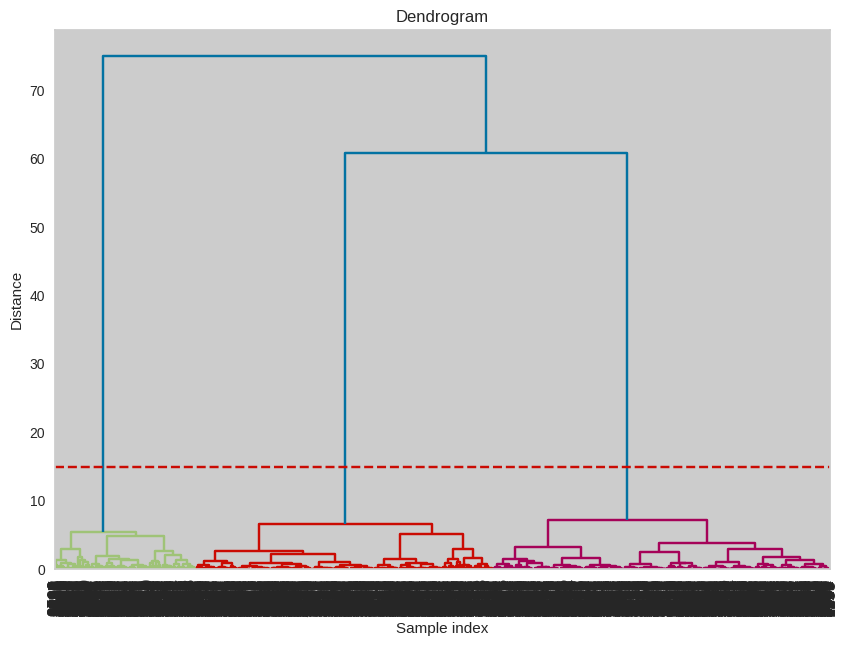

In [192]:
# Dendogram

from scipy.cluster.hierarchy import dendrogram, linkage

#  Generate the linkage matrix
Z = linkage(df, method='ward')  # You can use 'ward', 'complete', 'average', etc.

# Plot the Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--')  # Optional: add a horizontal line to indicate a cut-off (threshold)
plt.show()


'''
A dendrogram is a tree-like diagram that shows the arrangement of clusters at various levels of the hierarchy.

Cutting the Dendrogram:
You can "cut" the dendrogram at a specific height to decide how many clusters you want.
The height of the cut will determine the number of clusters; all branches below that height will form distinct clusters.

Choosing the Cut Level:
Look for large vertical spaces between horizontal lines in the dendrogram.
A large gap suggests a natural division between clusters, making it a good point to cut.
'''

In [194]:
silhouette_avg = silhouette_score(df, pred_H)
print(f'The silhouette score for the clustering is: {silhouette_avg:.3f}')

The silhouette score for the clustering is: 0.845


# **DBSCAN**

The DBSCAN algorithm operates in the following manner:

**Select a Point**:
Start with an arbitrary point from the dataset that has not been visited yet.

**Neighborhood Search:** Identify all points within the distance Eps from the selected point.

**Core Point Check:** If the number of points in this neighborhood (including the selected point) is greater than or equal to MinPts, the point is classified as a core point, and a new cluster is created. All points within Eps are added to this cluster.

**Expand the Cluster:** For each core point in the cluster, repeat the neighborhood search. If any of these points are also core points, include their neighbors in the cluster. Continue this process until no more points can be added to the cluster.

**Handle Border and Noise Points:** If a point is not a core point and not reachable from any core point, it is labeled as noise. Points reachable from core points but not core points themselves become border points of the respective cluster.

**Repeat:** Continue this process for all unvisited points in the dataset until all points are classified.

![DBSCAN](https://media.geeksforgeeks.org/wp-content/uploads/20240514120714/dbscan.jpg)

In [196]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.2,min_samples=4)
pred_DBSCAN=dbscan.fit_predict(df)
df['Cluster_DBSCAN']=pred_DBSCAN
df.head()

last transaction  InvoiceNo  TotalAmount  Cluster  Cluster_H  Cluster_DBSCAN
0          0.957105   0.030960     0.484200        2          2               0
1          0.048257   0.074303     0.473507        0          1               1
2          0.828418   0.016512     0.090092        1          0               2
3          0.793566   0.086687     0.675160        2          2               0
4          0.544236   0.003096     0.023978        1          0               2

In [198]:
dbscan.labels_

array([0, 1, 2, ..., 1, 0, 0])

In [199]:
silhouette_avg = silhouette_score(df, pred_DBSCAN)
print(f'The silhouette score for the clustering is: {silhouette_avg:.3f}')

The silhouette score for the clustering is: 0.851


In [201]:
# another way
score = silhouette_score(df, dbscan.labels_, metric='euclidean')
print(score)

0.8511313049052621
